In [ ]:
from IPython.display import clear_output

!pip install -U "ray[rllib]"
!pip install tianshou
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install mat4py

clear_output()

# LIBPackEnv

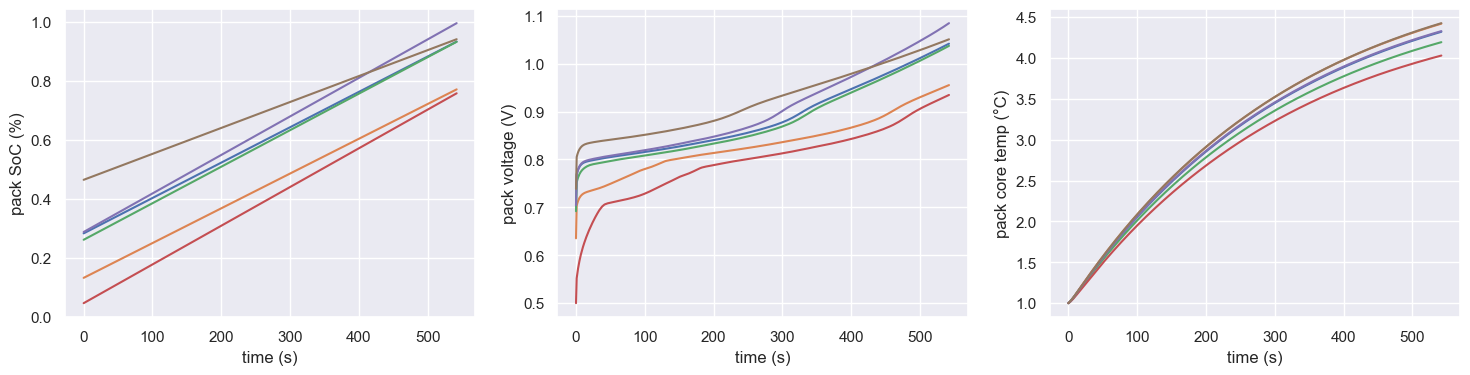

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from LIBEnv.LIB_gym import LIBPackEnv
import seaborn as sns
sns.set_theme()

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1)

pack_res=[]
rewards = []
pack_res.append(env.reset(0)[0].reshape(3,6))
done = False
while not done:
    next_state, reward, done, _, info = env.step(np.ones(7))
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)

pack_res = np.array(pack_res)
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(pack_res[:,0,:])
plt.xlabel('time (s)')
plt.ylabel('pack SoC (%)')
plt.grid('on')
plt.subplot(1,3,2)
plt.plot(pack_res[:,1,:])
plt.xlabel('time (s)')
plt.ylabel('pack voltage (V)')
plt.grid('on')
plt.subplot(1,3,3)
plt.plot(pack_res[:,2,:])
plt.xlabel('time (s)')
plt.ylabel('pack core temp (°C)')
plt.grid('on')

### Tensorboard 

In [ ]:
#@title Tensorboard - click the refresh button once training is running

%load_ext tensorboard
%tensorboard --logdir logs

# stable baseline3

In [ ]:
from stable_baselines3 import PPO, DDPG, A2C, TD3, SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
import os

timesteps = 1e7
log_dir = "./tmp/"

check_env(env, warn=True)
env = Monitor(env, log_dir+'monitor.csv', override_existing=False)
model = SAC("MlpPolicy", env, verbose=1,
            tensorboard_log="logs",
            learning_rate=1e-3,
            # buffer_size=int(1e6),
            # batch_size=1024,
            gamma=0.95,
            # tau=0.05,
            policy_kwargs=dict(net_arch=[32, 32, 32]))

callback = CheckpointCallback(save_freq=5e4, save_path=log_dir, name_prefix='battery_rl_model')

# Train the agent
# model = model.load('best_model.zip', env)
model.learn(total_timesteps=timesteps, callback=callback, progress_bar=False)

In [ ]:
model.actor

In [ ]:
model.critic

In [ ]:
model = model.load('./best_model', env)

In [ ]:
import pandas as pd
results = pd.read_csv('./tmp/monitor.csv')
returns = np.array(results.iloc[:,0].astype(float)).ravel()

window = 100
rolling_mean = pd.Series(returns).rolling(window).mean()
std = pd.Series(returns).rolling(window).std()

plt.figure(figsize=(8,5))
plt.plot(returns)
plt.plot(rolling_mean, color='red', linewidth=2.5)
plt.fill_between(range(len(rolling_mean)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.5)

plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid('on')

In [ ]:
import pandas as pd
results = pd.read_csv('./tmp/monitor.csv')
returns = np.array(results.iloc[:,1].astype(float)).ravel()

window = 100
rolling_mean = pd.Series(returns).rolling(window).mean()
std = pd.Series(returns).rolling(window).std()

plt.figure(figsize=(8,5))
plt.plot(returns)
plt.plot(rolling_mean, color='red', linewidth=2.5)
plt.fill_between(range(len(rolling_mean)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.5)

plt.xlabel('Episode')
plt.ylabel('Episode Length / Charge Duration (s)')
plt.grid('on')

In [ ]:
# model = model.load('tmp/battery_rl_model_8360000_steps.zip', env)
vec_env = model.get_env()
vec_env.seed(0)
state = vec_env.reset()

pack_res=[]
rewards = []
actions = []

done = False
pack_res.append(state.reshape(3,6))
while not done:
    action, _states = model.predict(state, deterministic=True)
    next_state, reward, done, info = vec_env.step(action)
    state = next_state
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)
    actions.append(action)

pack_res = np.array(pack_res)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(pack_res[:-1,0,:])
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(2,2,2)
plt.plot(pack_res[:-1,1,:])
plt.ylabel('pack voltage')
plt.grid('on')
plt.subplot(2,2,3)
plt.plot(pack_res[:-1,2,:])
plt.ylabel('pack core temp')
plt.grid('on')
plt.subplot(2,2,4)
plt.plot(np.array(actions)[:-1].reshape(-1,6+1)[:,:-1])
plt.plot(np.array(actions)[:-1].reshape(-1,6+1)[:,-1], "--", color='red')
plt.ylabel('current')
plt.grid('on')

In [ ]:
np.array(actions)[:-1].shape

In [ ]:
plt.plot(np.abs(pack_res[:-1,0,:] - np.mean(pack_res[:-1,0,:], axis=-1).reshape(-1,1)).sum(-1))
plt.xlabel('time')
plt.ylabel('Balance Cost')
plt.grid('on')
plt.ylim([0,0.2])

In [ ]:
plt.plot(pack_res[:-1,0,:].max(-1) - pack_res[:-1,0,:].min(-1))
plt.xlabel('time')
plt.ylabel('SOC dev')
plt.grid('on')
plt.ylim([0,0.2])

In [ ]:
np.abs(pack_res[:-1,0,:] - np.mean(pack_res[:-1,0,:], axis=-1).reshape(-1,1))

In [ ]:
np.mean(pack_res[:-1,0,:])

In [ ]:
pack_res[-2,0,:], np.std(pack_res[-2,0,:])

In [ ]:
model.save('./last_model.pth')

# Tianshu

In [ ]:
pip install tianshou

In [ ]:
import gymnasium as gym
import torch, numpy as np, torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import tianshou as ts

In [ ]:
lr, epoch, batch_size = 1e-3, 10, 64
train_num, test_num = 10, 100
gamma, n_step, target_freq = 0.9, 3, 320
buffer_size = 20000
eps_train, eps_test = 0.1, 0.05
step_per_epoch, step_per_collect = 10000, 10
logger = ts.utils.TensorboardLogger(SummaryWriter('log/dqn'))  # TensorBoard is supported!
# For other loggers: https://tianshou.readthedocs.io/en/master/tutorials/logger.html